# Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from timm.models import efficientnet_b0, efficientnet_b1
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import wandb
import matplotlib.pyplot as plt

In [25]:
!wandb login

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

train_images_path = "/kaggle/input/cleaned-dataset/dataset/train"
test_images_path = "/kaggle/input/cleaned-dataset/dataset/test" 
categories = ["grab", "lineman", "normal", "win"]

device: cuda


# Preprocessing

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.image_files = []
        self.labels = [] if not is_test else None
        self.is_test = is_test

        if is_test:
            self.image_files = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]
        else:
            for category in categories:
                category_path = os.path.join(root_dir, category)
                if os.path.exists(category_path):
                    for img_file in os.listdir(category_path):
                        file_path = os.path.join(category_path, img_file)
                        self.image_files.append(file_path)
                        label = categories.index(category)
                        self.labels.append(label)

        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        try:
            image = Image.open(img_name).convert('RGB')
        except (FileNotFoundError, Image.UnidentifiedImageError):
            return None

        if self.is_test:
            if self.transform:
                transformed = self.transform(image=np.array(image))
                image = transformed['image']
            return image, img_name
        else:
            label = self.labels[idx]
            if self.transform:
                transformed = self.transform(image=np.array(image))
                image = transformed['image']
            return image, torch.tensor(label, dtype=torch.long)


def custom_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None, None

    images, labels = zip(*batch)
    return torch.stack(images, dim=0), torch.tensor(labels, dtype=torch.long)

In [28]:
IMG_SIZE = 384
transform_train = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=20),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transform_test = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Training

In [ ]:
BATCH_SIZE = 32
train_dataset = ImageDataset(root_dir=train_images_path, transform=transform_train)
test_dataset = ImageDataset(root_dir=test_images_path, transform=transform_test, is_test=True)

# --- Hyperparameters ---
LEARNING_RATE = 1e-5
MAX_EPOCHS = 20
PATIENCE = 3
K_FOLDS = 5
criterion = nn.CrossEntropyLoss()
ETA_MIN = 1e-6

In [ ]:
# --- K-Fold Cross-Validation ---
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

best_fold_loss = float('inf')
best_fold_accuracy = 0.0
all_models = []

for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    
    # --- Start fold ---
    print(f"--- Fold {fold+1} ---")
    wandb.init(project="isquared-b1-20epoch", name=f"fold-{fold+1}", config={
        "learning_rate": LEARNING_RATE,
        "epochs": MAX_EPOCHS,
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "model": "EfficientNet-B1",
        "optimizer": "AdamW",
        "k_folds": K_FOLDS
    })

    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True, num_workers=4, collate_fn=custom_collate_fn)
    val_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=False, num_workers=4, collate_fn=custom_collate_fn)

    # Model Definition
    model = efficientnet_b1(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, len(categories))
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataloader) * MAX_EPOCHS, eta_min=ETA_MIN)


    # Training and Validation functions
    def train_model(model, train_dataloader, criterion, optimizer, scheduler, epoch):
        model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            if images is None or labels is None or images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        epoch_loss = running_loss / len(train_dataloader) if len(train_dataloader) > 0 else 0.0
        print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}")
        
        # Log to wandb
        wandb.log({"train_loss": epoch_loss, "epoch": epoch + 1})

        return epoch_loss

    def validate_model(model, val_dataloader, criterion):
        model.eval()
        running_loss = 0.0
        running_log_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
    
        with torch.no_grad():
            for images, labels in val_dataloader:
                if images is None or labels is None or images.size(0) == 0:
                    continue
    
                num_batches += 1
                images, labels = images.to(device), labels.to(device)
    
                outputs = model(images)
                
                # val loss (per batch)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
    
                # val log loss (per batch)
                probabilities = F.softmax(outputs, dim=1)
                one_hot_labels = F.one_hot(labels, num_classes=len(categories)).float()
                
                log_loss = -torch.sum(one_hot_labels * torch.log(probabilities + 1e-10)) / labels.size(0)
                running_log_loss += log_loss.item()

                # val acc (per batch)
                predicted = torch.max(outputs.data, 1)[1]
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        if num_batches == 0:
            print("Warning: No validation data processed!")
            return float('inf'), 0.0, float('inf')
    
        val_loss = running_loss / num_batches
        val_accuracy = 100 * correct / total
        val_log_loss = running_log_loss / num_batches
    
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}%, Val Log Loss: {val_log_loss:.4f}")
        
        # Log to wandb
        wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy, "val_log_loss": val_log_loss, "epoch": epoch + 1})
    
        return val_loss, val_accuracy, val_log_loss

    best_val_loss = float('inf')
    epochs_no_improvement = 0

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss = train_model(model, train_dataloader, criterion, optimizer, scheduler, epoch)
        val_loss, val_accuracy, val_log_loss = validate_model(model, val_dataloader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improvement = 0
            best_fold_model = model
            print("Best model for this fold updated!")
            
            # Save the best model in wandb
            torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")
            wandb.save(f"best_model_fold_{fold+1}.pth")
        else:
            epochs_no_improvement += 1

        if epochs_no_improvement >= PATIENCE:
            print(f"Early stopping after {epoch} epochs.")
            break

    torch.save(best_fold_model.state_dict(), f"best_model_fold_{fold+1}.pth")
    all_models.append(best_fold_model)

    if best_val_loss < best_fold_loss:
        best_fold_loss = best_val_loss
        best_fold_accuracy = val_accuracy
        best_overall_model = best_fold_model
        print(f"Best model for all folds updated!")

    wandb.finish()
    # --- End of fold ---


print(f"Best {K_FOLDS}-fold cross-validation loss: {best_fold_loss:.4f}")
print(f"Best {K_FOLDS}-fold cross-validation accuracy: {best_fold_accuracy:.4f}")

--- Fold 1 ---


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

Epoch 1, Train Loss: 1.2959
Val Loss: 1.1555, Val Accuracy: 62.35%, Val Log Loss: 1.1555
Best model for this fold updated!
Epoch 2, Train Loss: 0.9091
Val Loss: 0.6856, Val Accuracy: 80.49%, Val Log Loss: 0.6856
Best model for this fold updated!
Epoch 3, Train Loss: 0.5451
Val Loss: 0.4778, Val Accuracy: 84.76%, Val Log Loss: 0.4778
Best model for this fold updated!
Epoch 4, Train Loss: 0.3716
Val Loss: 0.3603, Val Accuracy: 87.35%, Val Log Loss: 0.3603
Best model for this fold updated!
Epoch 5, Train Loss: 0.2848
Val Loss: 0.3296, Val Accuracy: 89.02%, Val Log Loss: 0.3296
Best model for this fold updated!
Epoch 6, Train Loss: 0.2319
Val Loss: 0.2928, Val Accuracy: 90.24%, Val Log Loss: 0.2928
Best model for this fold updated!
Epoch 7, Train Loss: 0.2015
Val Loss: 0.3087, Val Accuracy: 88.57%, Val Log Loss: 0.3087
Epoch 8, Train Loss: 0.1540
Val Loss: 0.2733, Val Accuracy: 90.40%, Val Log Loss: 0.2733
Best model for this fold updated!
Epoch 9, Train Loss: 0.1491
Val Loss: 0.2894, Val 

epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
train_loss,█▆▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇███████
val_log_loss,█▄▃▂▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁
epoch,12
train_loss,0.11046
val_accuracy,89.48171
val_log_loss,0.27875
val_loss,0.27875


--- Fold 2 ---


Epoch 1, Train Loss: 1.3043
Val Loss: 1.1615, Val Accuracy: 61.74%, Val Log Loss: 1.1615
Best model for this fold updated!
Epoch 2, Train Loss: 0.9603
Val Loss: 0.7101, Val Accuracy: 81.86%, Val Log Loss: 0.7101
Best model for this fold updated!
Epoch 3, Train Loss: 0.5865
Val Loss: 0.4554, Val Accuracy: 85.37%, Val Log Loss: 0.4554
Best model for this fold updated!
Epoch 4, Train Loss: 0.3944
Val Loss: 0.3460, Val Accuracy: 89.02%, Val Log Loss: 0.3460
Best model for this fold updated!
Epoch 5, Train Loss: 0.2975
Val Loss: 0.3376, Val Accuracy: 88.87%, Val Log Loss: 0.3376
Best model for this fold updated!
Epoch 6, Train Loss: 0.2417
Val Loss: 0.2893, Val Accuracy: 90.24%, Val Log Loss: 0.2893
Best model for this fold updated!
Epoch 7, Train Loss: 0.2082
Val Loss: 0.2823, Val Accuracy: 89.94%, Val Log Loss: 0.2823
Best model for this fold updated!
Epoch 8, Train Loss: 0.1648
Val Loss: 0.2743, Val Accuracy: 90.24%, Val Log Loss: 0.2743
Best model for this fold updated!
Epoch 9, Train L

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▆▇▇█████████
val_log_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁
epoch,15
train_loss,0.06224
val_accuracy,91.61585
val_log_loss,0.26953
val_loss,0.26953


--- Fold 3 ---


Epoch 1, Train Loss: 1.3271
Val Loss: 1.2047, Val Accuracy: 54.73%, Val Log Loss: 1.2047
Best model for this fold updated!
Epoch 2, Train Loss: 1.0009
Val Loss: 0.7358, Val Accuracy: 79.42%, Val Log Loss: 0.7358
Best model for this fold updated!
Epoch 3, Train Loss: 0.6080
Val Loss: 0.4461, Val Accuracy: 87.04%, Val Log Loss: 0.4461
Best model for this fold updated!
Epoch 4, Train Loss: 0.4097
Val Loss: 0.3380, Val Accuracy: 88.72%, Val Log Loss: 0.3380
Best model for this fold updated!
Epoch 5, Train Loss: 0.3209
Val Loss: 0.2920, Val Accuracy: 89.94%, Val Log Loss: 0.2920
Best model for this fold updated!
Epoch 6, Train Loss: 0.2691
Val Loss: 0.2606, Val Accuracy: 91.46%, Val Log Loss: 0.2606
Best model for this fold updated!
Epoch 7, Train Loss: 0.2013
Val Loss: 0.2596, Val Accuracy: 91.16%, Val Log Loss: 0.2596
Best model for this fold updated!
Epoch 8, Train Loss: 0.1880
Val Loss: 0.2193, Val Accuracy: 92.07%, Val Log Loss: 0.2193
Best model for this fold updated!
Epoch 9, Train L

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▇▇▇████████
val_log_loss,█▅▃▂▂▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁
epoch,14
train_loss,0.07514
val_accuracy,92.53049
val_log_loss,0.22541
val_loss,0.22541


--- Fold 4 ---


Epoch 1, Train Loss: 1.3003
Val Loss: 1.1672, Val Accuracy: 60.00%, Val Log Loss: 1.1672
Best model for this fold updated!
Epoch 2, Train Loss: 0.9392
Val Loss: 0.6857, Val Accuracy: 80.76%, Val Log Loss: 0.6857
Best model for this fold updated!
Epoch 3, Train Loss: 0.5651
Val Loss: 0.4300, Val Accuracy: 87.18%, Val Log Loss: 0.4300
Best model for this fold updated!
Epoch 4, Train Loss: 0.3788
Val Loss: 0.3247, Val Accuracy: 89.31%, Val Log Loss: 0.3247
Best model for this fold updated!
Epoch 5, Train Loss: 0.3153
Val Loss: 0.3003, Val Accuracy: 89.77%, Val Log Loss: 0.3003
Best model for this fold updated!
Epoch 6, Train Loss: 0.2425
Val Loss: 0.2768, Val Accuracy: 89.62%, Val Log Loss: 0.2768
Best model for this fold updated!
Epoch 7, Train Loss: 0.1984
Val Loss: 0.2317, Val Accuracy: 91.45%, Val Log Loss: 0.2317
Best model for this fold updated!
Epoch 8, Train Loss: 0.1617
Val Loss: 0.2410, Val Accuracy: 90.69%, Val Log Loss: 0.2410
Epoch 9, Train Loss: 0.1293
Val Loss: 0.2451, Val 

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇▇█▇████████
val_log_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,17
train_loss,0.05014
val_accuracy,93.58779
val_log_loss,0.24282
val_loss,0.24282


--- Fold 5 ---


Epoch 1, Train Loss: 1.3208
Val Loss: 1.1951, Val Accuracy: 53.28%, Val Log Loss: 1.1951
Best model for this fold updated!
Epoch 2, Train Loss: 0.9778
Val Loss: 0.7392, Val Accuracy: 79.08%, Val Log Loss: 0.7392
Best model for this fold updated!
Epoch 3, Train Loss: 0.6335
Val Loss: 0.4901, Val Accuracy: 86.11%, Val Log Loss: 0.4901
Best model for this fold updated!
Epoch 4, Train Loss: 0.4178
Val Loss: 0.3628, Val Accuracy: 89.16%, Val Log Loss: 0.3628
Best model for this fold updated!
Epoch 5, Train Loss: 0.3138
Val Loss: 0.3246, Val Accuracy: 89.01%, Val Log Loss: 0.3246
Best model for this fold updated!
Epoch 6, Train Loss: 0.2440
Val Loss: 0.2988, Val Accuracy: 90.53%, Val Log Loss: 0.2988
Best model for this fold updated!
Epoch 7, Train Loss: 0.2069
Val Loss: 0.2625, Val Accuracy: 91.60%, Val Log Loss: 0.2625
Best model for this fold updated!
Epoch 8, Train Loss: 0.1736
Val Loss: 0.2672, Val Accuracy: 92.06%, Val Log Loss: 0.2672
Epoch 9, Train Loss: 0.1481
Val Loss: 0.2600, Val 

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████████
val_log_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁
epoch,15
train_loss,0.07739
val_accuracy,91.60305
val_log_loss,0.28694
val_loss,0.28694


Best 5-fold cross-validation loss: 0.2086
Best 5-fold cross-validation accuracy: 92.5305


In [ ]:
# wandb.finish()

In [ ]:
# --- Stacked Model (Ensemble) ---
def stacked_prediction(images, models):
    all_predictions = []
    for model in models:
        with torch.no_grad():
            outputs = model(images)
            predictions = F.softmax(outputs, dim=1)
            all_predictions.append(predictions)

    # averaging 
    stacked_pred = torch.mean(torch.stack(all_predictions), dim=0)
    return stacked_pred

# --- Submission ---
def generate_predictions_stacked(models, test_dir, output_file):
    results = []
    for image_file in os.listdir(test_dir):
        image_path = os.path.join(test_dir, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
        except (FileNotFoundError, Image.UnidentifiedImageError):
            continue
        transformed = transform_test(image=np.array(image))['image'].unsqueeze(0).to(device)

        stacked_pred = stacked_prediction(transformed, models)
        prediction = stacked_pred.detach().cpu().numpy().flatten()
        results.append([image_file] + list(prediction))

    pd.DataFrame(results, columns=['id'] + categories).to_csv(output_file, index=False)
    print("Predictions saved")

generate_predictions_stacked(all_models, test_images_path, '/kaggle/working/submission_stacked.csv')

Predictions saved


Image 1 (/kaggle/input/cleaned-dataset/dataset/test/8e672f1081fbe81887c75f6913b681fe.jpeg): 0.00 0.00 0.00 1.00


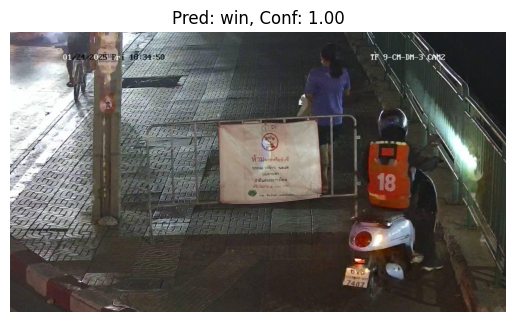

Image 2 (/kaggle/input/cleaned-dataset/dataset/test/9a50484cbc4f4360f6ddd952ee2836cc.jpeg): 0.98 0.01 0.01 0.00


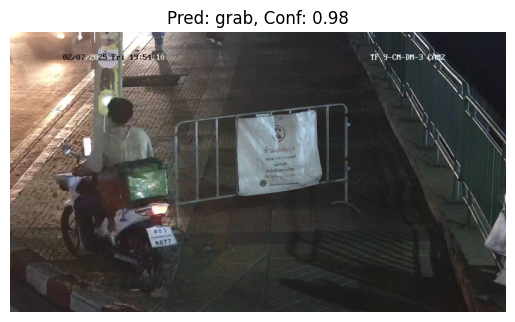

Image 3 (/kaggle/input/cleaned-dataset/dataset/test/747966b084c410bdc3f35e97325f1cc2.jpeg): 0.00 0.00 0.99 0.01


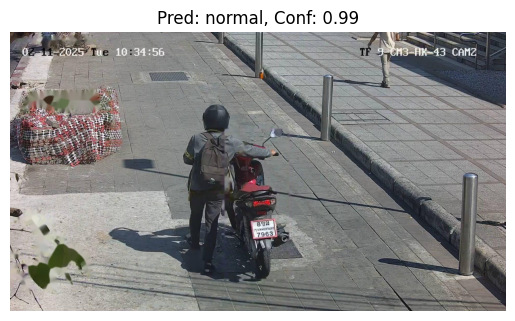

Image 4 (/kaggle/input/cleaned-dataset/dataset/test/2bdb29951e7d6d5e594e7f341e97e867.jpeg): 0.98 0.00 0.01 0.00


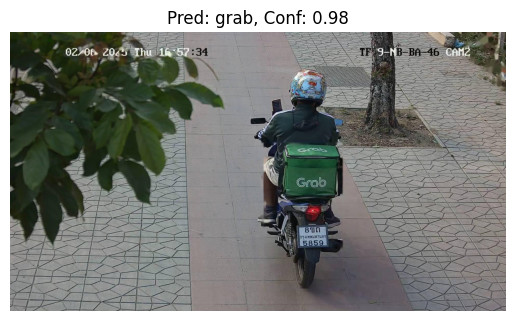

Image 5 (/kaggle/input/cleaned-dataset/dataset/test/740577e97979e15ad2438fb04073a9b8.jpeg): 0.41 0.58 0.01 0.01


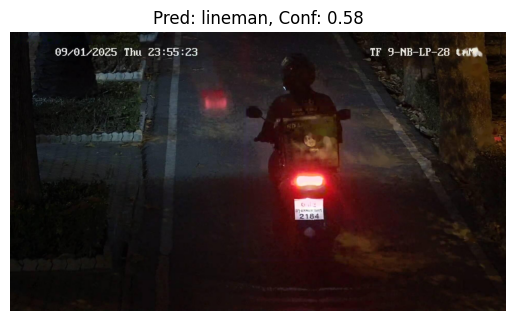

In [ ]:
def visualize_predictions_stacked(models, device, idx_to_class, test_dir, num_samples=5):
    test_dataset = ImageDataset(root_dir=test_dir, transform=transform_test, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    test_iter = iter(test_loader)
    
    with torch.no_grad():
        for i in range(num_samples):
            try:
                img, filename = next(test_iter)
            except StopIteration:
                print("Not enough images in the test set.")
                break
            
            img = img.to(device)
            stacked_pred = stacked_prediction(img, models)
            y_hat = stacked_pred.cpu().numpy().flatten()
            predicted_class = np.argmax(y_hat)
            confidence = y_hat[predicted_class]

            filename_str = filename[0] if isinstance(filename[0], str) else str(filename[0])

            img_path = os.path.join(test_dir, filename_str)
            if not os.path.exists(img_path):
                print(f"Warning: {img_path} does not exist.")
                continue
            
            img_display = Image.open(img_path)

            probs_str = " ".join([f"{prob:.2f}" for prob in y_hat])
            print(f"Image {i+1} ({filename_str}): {probs_str}")

            plt.figure()
            plt.imshow(img_display)
            plt.axis("off")
            plt.title(f"Pred: {idx_to_class[predicted_class]}, Conf: {confidence:.2f}")
            plt.show()

idx_to_class = {i: category for i, category in enumerate(categories)}

visualize_predictions_stacked(all_models, device, idx_to_class, test_images_path, num_samples=5)